# Тестовое задание - нахождение кончиков пальцев на изображении

Задача - написать программу, которая бы принимала на вход изображение, отмечала на нем красной точкой кончики пальцев и обводила ладонь синим контуром. Даны черно-белые изображения, на которых видно руку.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import math

In [2]:
#filename = input('Поместите изображение в папку со скриптом и введите его полное имя, включая расширение:\n')
filename = 'hand1.bmp'

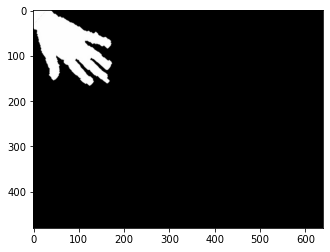

In [3]:
try:
    img = cv2.imread(filename)
    plt.imshow(img)
except:
    print('Ошибка загрузки файла, проверьте имя и расположение файла')
    quit()

In [4]:
# добавим картинке размытие
blur = cv2.GaussianBlur(img, (3,3), 75)
#plt.imshow(blur, cmap = 'gray')

In [5]:
# переведем картинку в градации серого
gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)
#plt.imshow(gray, cmap = 'gray')

In [6]:
# переведем изображение в черно-белое
_, thresh = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
#plt.imshow(thresh, cmap='gray')

In [7]:
# найдем контуры на изображении
contours, hierarchy = cv2.findContours(thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE )

In [8]:
# Выберем из всех возможных контуров контур с максимальной длиной
len_max, ind_max = 0, 0
for i in range(0, len(contours)):
    if len(contours[i]) > len_max:
        len_max = len(contours[i])
        ind_max = i
cnt = contours[ind_max]

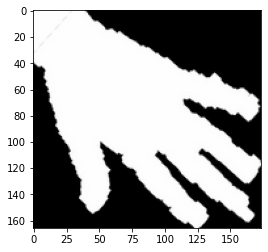

In [9]:
# впишем контур ладони в прямоугольник с точками x, y, x+w, y+h
x,y,w,h = cv2.boundingRect(cnt)
plt.imshow(img[y:y+h, x:x+w])

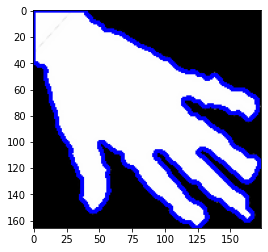

In [10]:
# выделим контур ладони синим цветом
img_copy = img.copy()
blue_cnt = cv2.drawContours(img_copy, [cnt], contourIdx = -1, color = (0, 0, 255), thickness = 2)
plt.imshow(blue_cnt[y:y+h, x:x+w])
# в дальнейшем будем накладывать новые элементы на это изображение

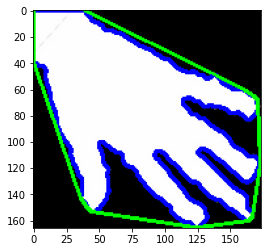

In [11]:
# найдем выпуклый контур ладони (convex hull)
hull = cv2.convexHull(cnt, returnPoints=False)
img_copy = blue_cnt.copy()
img_hull = cv2.polylines(img_copy, pts=[cnt[hull].reshape(-1,2)], isClosed=False, color=(0,255,0),
                         lineType=cv2.FILLED, thickness=2)
plt.imshow(img_hull[y:y+h, x:x+w])

In [12]:
# найдем "дефекты" выпуклости - каждый дефект выпуклости представлен как 4-элементный целочисленный вектор
# (также известный как Vec4i): (start_index, end_index, farthest_pt_index, fixpt_depth),
# где индексы - это индексы начальной, средней и конечной точек в исходном контуре,
# а fixpt_depth - это расстояние между средней точкой и прямой между начальной и конечной точкой контура
# если по простому, то каждый дефект апроксимируется в треугольник
convexityDefects = cv2.convexityDefects(cnt, hull)
# выведем первые 5 векторов
convexityDefects[:5]

array([[[    1,    58,     8,  1833]],

       [[   58,    62,    59,   238]],

       [[   63,   128,    93, 13760]],

       [[  129,   193,   162, 15790]],

       [[  194,   235,   209, 12494]]], dtype=int32)

In [13]:
# выкинем из дефектов последний элемент - расстояние
# останутся индексы начальной, конечной и средней точек
defect_points = convexityDefects[:,:,:3]
# отсортируем каждый вектор по возрастанию
defect_points.sort()
# разложим многомерный массив дефектов в одномерный вектор
defect_points = defect_points.reshape(-1)
defect_points

array([  1,   8,  58,  58,  59,  62,  63,  93, 128, 129, 162, 193, 194,
       209, 235, 236, 263, 296, 297, 300, 301, 301, 304, 316, 316, 331,
       380], dtype=int32)

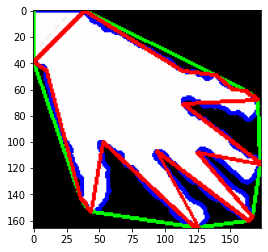

In [14]:
# изобразим наглядно дефекты выпуклости, соединим все точки красной линией
img_copy = img_hull.copy()
img_hull_def = cv2.drawContours(img_copy, [cnt[defect_points]] ,
                                contourIdx = -1, color = (255, 0, 0), thickness=2)
plt.imshow(img_hull_def[y:y+h, x:x+w])

По сути дефекты выпуклости это пустое пространство между пальцами. Начальная и конечная точки каждого вектора дефектов это кончики пальцев в идеале. В нашем же случае мы имеем изображение с неровными краями, на мизинце видим сильные неровности, которые мешают идентификации.

Чтобы наглядно проиллюстрировать, что такое дефект выпуклости, введем 3-мерный вектор каждого дефекта с координатами точек, его составляющих.

In [15]:
# сформируем массив "треугольников" дефектов выпуклостей
defect_triangles = cnt[defect_points].reshape(-1,3,2)

Нарисуем отдельно каждый дефект для наглядности.

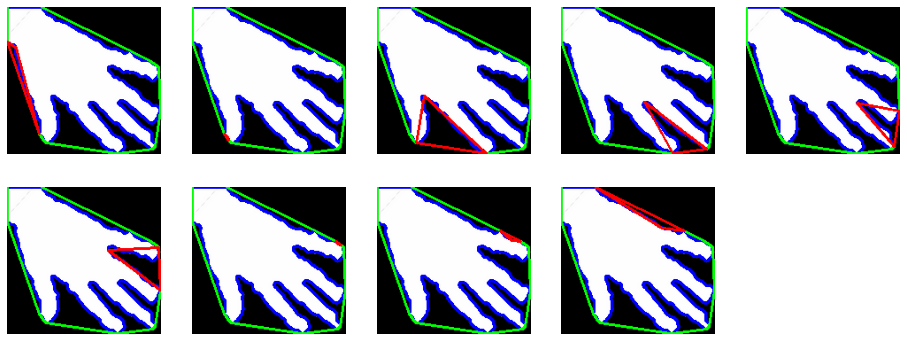

In [16]:
try:
    fig = plt.figure(figsize=(16,16))
    for index, triangle in enumerate(defect_triangles):
        img_copy = img_hull.copy()
        img_hull_def = cv2.drawContours(img_copy, [triangle], contourIdx = -1, color = (255, 0, 0), thickness=2)
        fig.add_subplot(5, 5, index + 1)
        plt.axis('off')
        plt.imshow(img_hull_def[y:y+h, x:x+w], cmap='gray')
except:
    pass

Чтобы найти кончики пальцев, нам нужны выбрать только те области, которые примыкают к кончикам пальцев. Для этого будем искать угол при средней точке каждой области. Обратим внимание, что углы в областях между пальцами гораздо меньше, чем в остальных случаях.

Напишем функцию получения углов по каждому из дефектов.

In [17]:
def get_angles(arr):
    angles = []
    # преобразуем массив, понижая количество измерений
    arr = cnt[arr.reshape(-1,3)].reshape(-1,3,2)
    # arr[0] - первое множество точек (3 точки)
    # arr[0][0] - первая точка
    # arr[0][0][0] - координата x 1й точки 1го множества точек
    # arr[0][0][1] - координата y 1й точки 1го множества точек
    for i in range(0, len(arr)):
        # находим координаты х и у каждой точки
        x1, x2, x3 = arr[i][0][0], arr[i][1][0], arr[i][2][0]
        y1, y2, y3 = arr[i][0][1], arr[i][1][1], arr[i][2][1]
        # находим дельта по х и по у для обоих векторов
        ax, ay, bx, by = x1 - x2, y1 - y2, x3 - x2, y3 - y2
        # находим угол через теорему косинусов
        angle = math.acos( (ax * bx + ay * by) / (math.sqrt(ax**2 + ay**2) * math.sqrt(bx**2 + by**2)) )
        # переводим из радиан в углы
        angle = math.degrees(angle)
        angles.append(angle)    
    return angles

In [18]:
# выведем углы при всех средних точках каждого их дефектов
angles = get_angles(defect_points)
angles

[139.9969405814189,
 153.434948822922,
 56.758634509592405,
 23.982493784879797,
 38.7790500788404,
 40.345983242369165,
 153.43494882292202,
 145.4742348282258,
 155.32059616587227]

Заметим, что угол между большим и указательным пальцами у некоторых людей может быть и более 90 градусов. Выставим ограничение по углу в 100 градусов.

In [19]:
# получим индексы искомых областей между пальцами (номера треугольников)
good_angles_idx = []
for i, a in enumerate(angles):
    if a < 100:
        good_angles_idx.append(i)
    else:
        pass
good_angles_idx

[2, 3, 4, 5]

In [20]:
# вернем массив с точками дефектов в изначальный вид - массив векторов по 3 точки
defect_points = defect_points.reshape(-1,3)
defect_points

array([[  1,   8,  58],
       [ 58,  59,  62],
       [ 63,  93, 128],
       [129, 162, 193],
       [194, 209, 235],
       [236, 263, 296],
       [297, 300, 301],
       [301, 304, 316],
       [316, 331, 380]], dtype=int32)

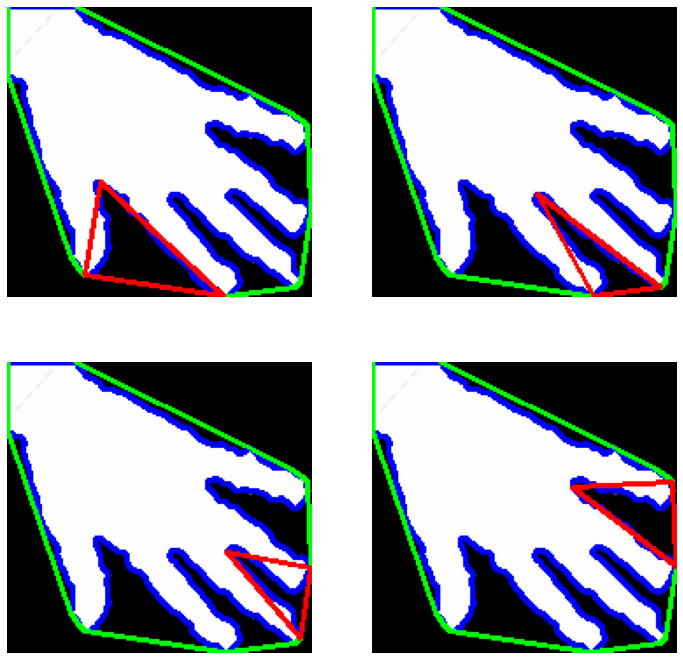

In [21]:
# найдем окончательные "дефекты" - области
final_triangles = cnt[defect_points[good_angles_idx].reshape(-1)].reshape(-1,3,2)
# нарисуем финальные области
fig = plt.figure(figsize=(12,12))
for index, triangle in enumerate(final_triangles):
    img_copy = img_hull.copy()
    img_hull_def = cv2.drawContours(img_copy, [triangle], contourIdx = -1, color = (255, 0, 0), thickness=2)
    fig.add_subplot(2, 2, index + 1)
    plt.axis('off')
    plt.imshow(img_hull_def[y:y+h, x:x+w])

In [22]:
# сформируем окончательный массив из областей
# исключим из каждой области среднюю точку
# в итоге останутся только начало и конец каждого "дефекта"
final_points = defect_points[good_angles_idx][:,0:3:2]
final_points

array([[ 63, 128],
       [129, 193],
       [194, 235],
       [236, 296]], dtype=int32)

В финале получили 4 области по 2 точки в каждой. Необходимо извлечь из них 5 точек. Смежные области в идеале имеют одинаковые пограничные точки, но могут быть и исключения из-за изображений плохого качества. Поэтому воспользуемся библиотекой sklearn, а именно методом k-ближайших соседей: найдем 5 центроидов для 8 точек. Если координаты центроида оказываются дробными - округляем до целого.

По сути решаем задачу кластеризации.

In [23]:
# формируем датасет для кластеризации
data = cnt[final_points].reshape(-1,2)

# подгружаем и обучаем модель
model = KMeans(n_clusters=5, random_state=42)
model.fit(data)

# формируем координаты центроидов
final_points = model.cluster_centers_.astype(int)
final_points

array([[165, 158],
       [ 44, 153],
       [173, 116],
       [124, 165],
       [171,  68]])

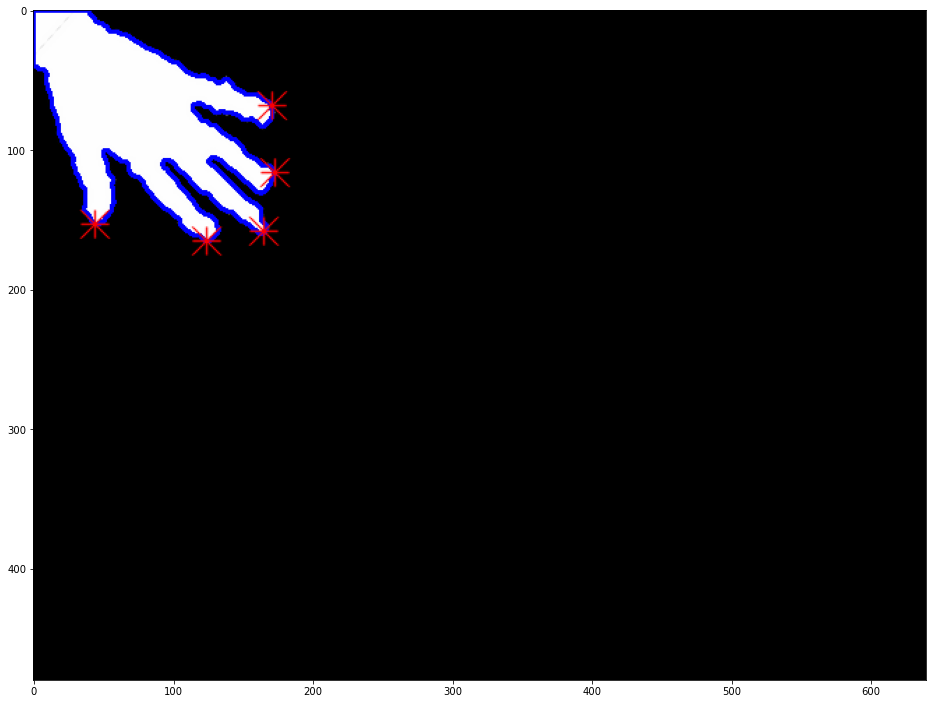

In [24]:
# Финальное изображение
img_copy = blue_cnt.copy()
for item in final_points:
    cv2.drawMarker(img_copy, (item[0], item[1]), color=(255,0,0), markerType=cv2.MARKER_STAR,
                   markerSize=20, thickness=1, line_type=cv2.LINE_AA)
plt.figure(figsize=(16,16))
plt.imshow(img_copy)